# Import

In [1]:
from helpers import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
from urllib.parse import unquote

# Downloading the data

In [2]:
dfs = preprocessing()

In [3]:
dfs['paths_finished']

,timestamp,durationInSec,path
0,1297740409,166,14th_century;15th_century;16th_century;Pacific...
1,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...
2,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
3,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
4,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
...,...,...,...
51313,1349231015,66,Yagan;Ancient_Egypt;Civilization
51314,1300254138,165,Yagan;Folklore;Brothers_Grimm;.Folklore;19th_c...
51315,1385095372,228,Yagan;Australia;England;France;United_States;T...
51316,1298792567,56,"Yarralumla,_Australian_Capital_Territory;Austr..."


## P2_notenook

## Mon code

In [4]:
import pandas as pd

# Sample DataFrame
data = {'word_lists': [['apple', '.orange', 'banana', '.wiski'], ['grape', 'kiwi', '.pineapple'], ['pear', 'melon', 'cherry']]}
df = pd.DataFrame(data)

# Function to split the list based on '.' prefix
def split_list_on_prefix(row):
    list_ = []
    row_ = []
    for word in row:
        if word.startswith('.'):
            row_.append(list_)
            list_ = [word[1:]]
        else:
            list_.append(word)  
    row_.append(list_)
    return row_

a = pd.DataFrame(dfs['paths_finished'].path.copy().str.split(';'))
a.path = [split_list_on_prefix(r) for r in a.path]
a



,path
0,"[[14th_century, 15th_century, 16th_century, Pa..."
1,"[[14th_century, Europe, Africa, Atlantic_slave..."
2,"[[14th_century, Niger, Nigeria, British_Empire..."
3,"[[14th_century, Renaissance, Ancient_Greece, G..."
4,"[[14th_century, Italy, Roman_Catholic_Church, ..."
...,...
51313,"[[Yagan, Ancient_Egypt, Civilization]]"
51314,"[[Yagan, Folklore, Brothers_Grimm], [Folklore,..."
51315,"[[Yagan, Australia, England, France, United_St..."
51316,"[[Yarralumla,_Australian_Capital_Territory, Au..."


In [5]:
# Create a list with all the peopls name
list_people = dfs['categories'].copy()[dfs['categories']['category'].str.contains('subject.People.')].article

# Look for all the finished path that target a people from the above list
path_target_people = pd.DataFrame(dfs['paths_finished'].path.copy().str.split(';'))
path_target_people['target'] = path_target_people.path.apply(lambda x: x[-1])
path_target_people = path_target_people[path_target_people.target.isin(list_people)]

#Remove all the path of length 1 (directly on the correct page)
path_target_people = path_target_people[path_target_people['path'].apply(lambda x: len(x) >= 2)]

# Separate the case of returns into list of list
path_target_people.path = [split_list_on_prefix(r) for r in path_target_people.path]

# Count the occurence of each name in target
target_distribution = path_target_people.target.value_counts()
path_target_people = path_target_people.merge(target_distribution, on = 'target', how = 'left')
path_target_people

target_people_list = path_target_people.target.drop_duplicates()
print(len(list_people), len(target_people_list))
display(target_people_list)

689 454


0              John_F._Kennedy
2       Elizabeth_I_of_England
7          Henry_David_Thoreau
8           Buckminster_Fuller
9          James_II_of_England
                 ...          
4254            Witold_Pilecki
4296            Donald_Bradman
4686              Sandy_Koufax
4738            Hannibal_Barca
5011               Franz_Kafka
Name: target, Length: 454, dtype: object

### Remark: !!! Verify preprocess we have all the possible names 
Not all the people articles are targeted in the game (454 target are people out of the 689 possible names)

In [6]:
path_target_people

,path,target,count
0,"[[14th_century, Italy, Roman_Catholic_Church, ...",John_F._Kennedy,22
1,"[[14th_century, Europe, North_America, United_...",John_F._Kennedy,22
2,"[[14th_century, England, London, Spanish_Armad...",Elizabeth_I_of_England,20
3,"[[14th_century, England, James_I_of_England, E...",Elizabeth_I_of_England,20
4,"[[14th_century, Hundred_Years'_War, Henry_VI_o...",Elizabeth_I_of_England,20
...,...,...,...
5905,"[[StarCraft, Macintosh, IPod, ITunes, Music, L...",Wolfgang_Amadeus_Mozart,25
5906,"[[Thrush_(bird), Bird, Vertebrate, Human, Unit...",Michael_Jordan,51
5907,"[[Tropical_Storm_Matthew_(2004), United_States...",Edward_Jenner,5
5908,"[[William_Thomson,_1st_Baron_Kelvin, Glasgow, ...",William_Shakespeare,30


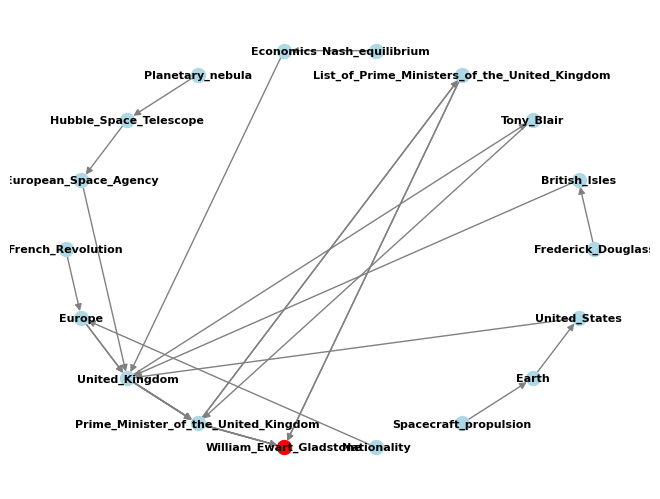

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.MultiDiGraph()


#j =110
j = 110
for people in target_people_list.iloc[j:j+1]:
    target_article = people

    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                G.add_edge(partial_path[k], partial_path[k+1])

# Draw the graph
    #Node size:
    nd = 100
    pos = nx.shell_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=nd, node_color='lightblue', font_color='black', font_size=8, edge_color='gray')

# Highlight the target article
    nx.draw_networkx_nodes(G, pos, nodelist=[target_article], node_color='red', node_size=nd)

    plt.show()


return
return
return
return


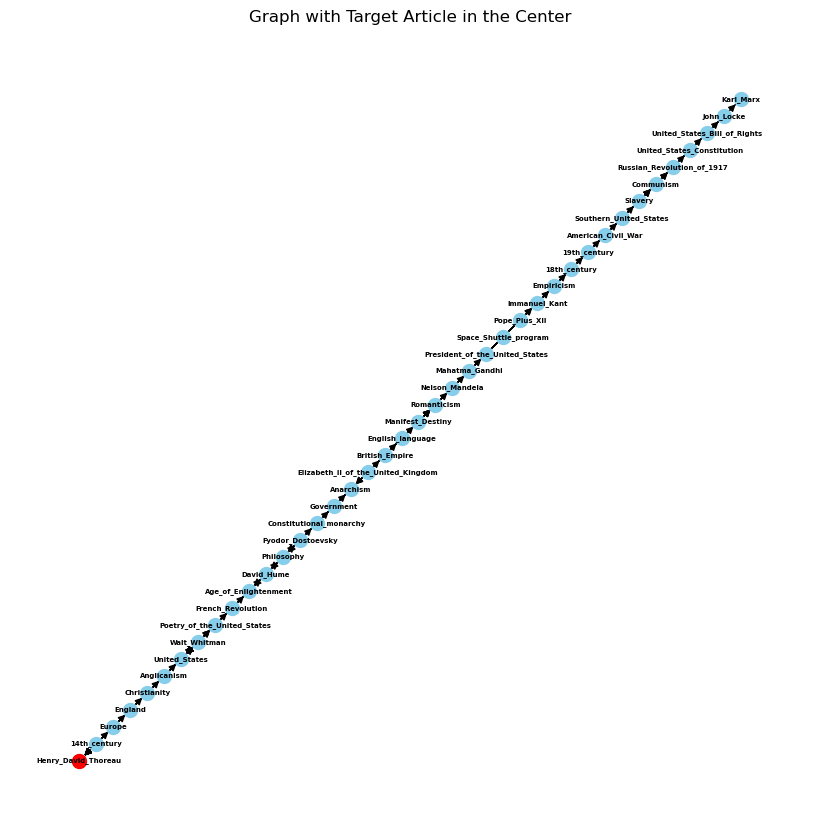

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

fs = (8, 8)
# Create a directed graph
G = nx.MultiDiGraph()
j = 2

for people in target_people_list.iloc[j:j+1]:
    target_article = people
    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            if j > 1:
                print('return')
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                G.add_edge(partial_path[k], partial_path[k+1])

    # Set the custom layout with the target article in the center
    layout = {target_article: tuple(element/2 for element in fs)}
    a = tuple((element+1)/2 for element in fs)
    for node in G.nodes:
        if node != target_article:
            layout[node] = a  # You can adjust these coordinates based on your preference
            a = tuple(element+(1/2) for element in a)
plt.figure(figsize=fs)
# Draw the graph
nx.draw(G, layout, with_labels=True, node_size=100, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', arrowsize=10)

# Highlight the target article
nx.draw_networkx_nodes(G, layout, nodelist=[target_article], node_color='red', node_size=100)

plt.title("Graph with Target Article in the Center")
plt.show()


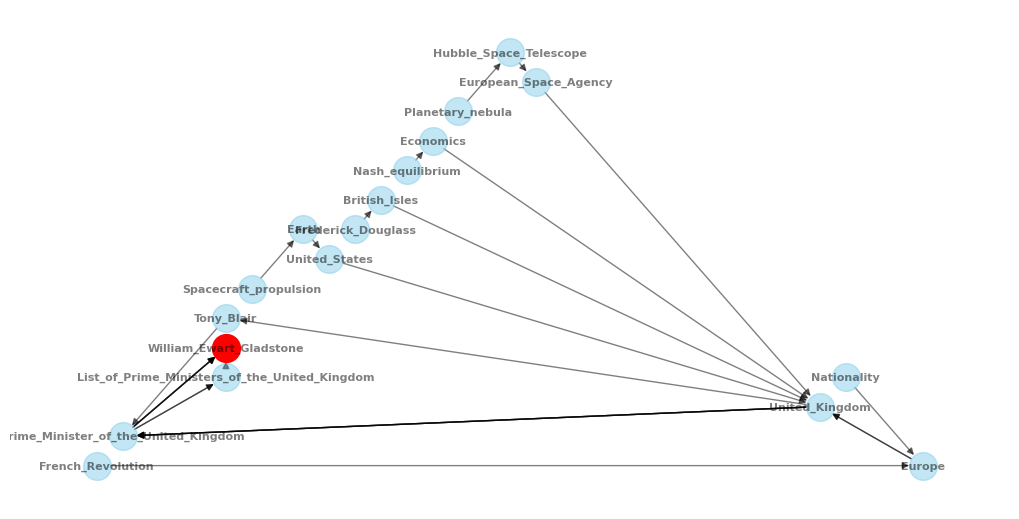

In [9]:
graph = nx.MultiDiGraph()


j = 110
for people in target_people_list.iloc[j:j+1]:
    target_article = people
    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            if j > 1:
                print('return')
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                graph.add_edge(partial_path[k], partial_path[k+1])


 
#nx.draw_networkx_nodes(graph, pos, node_size=10)  #, node_color=node_colors)
#nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.figure(figsize=(10, 5))
    pos = nx.planar_layout(graph) 
    nx.draw(graph, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10, alpha = 0.5)
    nx.draw_networkx_nodes(graph, pos, nodelist=[target_article], node_color='red', node_size=400)


plt.show()


Francis_Bacon
{'Age_of_Enlightenment': (462.92, 1215.3), 'Renaissance': (1458.5, 802.94), 'Philosophy': (1301.9, 996.53), 'Neighbours': (935.3, 1241.5), 'Australia': (822.93, 1180.5), 'United_Kingdom': (1062.9, 1035.7), 'Charles_Darwin': (1242.0, 956.53), 'String_theory': (1034.8, 634.38), 'Albert_Einstein': (964.16, 648.43), 'United_States': (893.54, 662.48), 'American_English': (822.93, 676.52), 'British_English': (752.31, 690.57), 'British_Empire': (681.69, 704.62), 'Francis_Drake': (611.08, 718.66), 'Elizabeth_I_of_England': (540.46, 732.71), 'Switzerland': (1105.4, 620.34), 'English_language': (1176.0, 606.29), 'England': (1246.6, 592.24), 'Bill_Gates': (466.55, 320.14), 'Science': (344.0, 356.52), 'Chemistry': (187.38, 802.94), 'Alchemy': (157.73, 952.06), 'History_of_science': (164.4, 1116.5), 'Richard_Feynman': (284.14, 316.51), 'Isaac_Newton': (224.27, 276.51), 'Middle_Ages': (462.92, 137.73), 'University': (696.51, 40.975), 'Nature': (949.35, 40.975), 'University_of_Cambridge

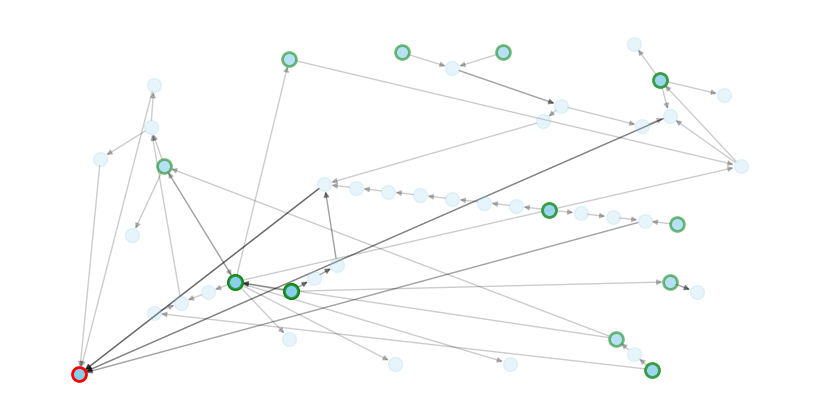

Voltaire
{'Age_of_Enlightenment': (759.36, 446.89), 'William_Shakespeare': (696.85, 671.95), 'Romanticism': (649.7, 617.54), 'French_Revolution': (656.23, 501.17), 'Supply_and_demand': (503.67, 148.99), 'Europe': (275.78, 386.04), 'France': (444.69, 559.27), 'French_language': (454.93, 630.54), 'Napoleonic_Wars': (294.31, 607.44), 'Battle_of_Austerlitz': (264.4, 672.94), 'Louis_XIV_of_France': (621.2, 284.61), 'Cologne': (552.11, 304.9), 'Weimar_Republic': (483.03, 325.18), 'Germany': (413.95, 345.47), 'Otto_von_Bismarck': (344.86, 365.75), 'Renaissance': (232.23, 228.69), 'Philosophy': (171.66, 189.76), 'John_Locke': (53.945, 345.47), 'Political_philosophy': (828.45, 467.18), 'Wheat': (454.93, 60.399), 'Spain': (171.66, 501.17), 'Glorious_Revolution': (690.28, 264.33), 'Adam_Smith': (602.55, 127.81), 'Ethics': (264.4, 18.0), 'Isaac_Newton': (111.09, 150.84), 'Voltaire': array([0, 0])}


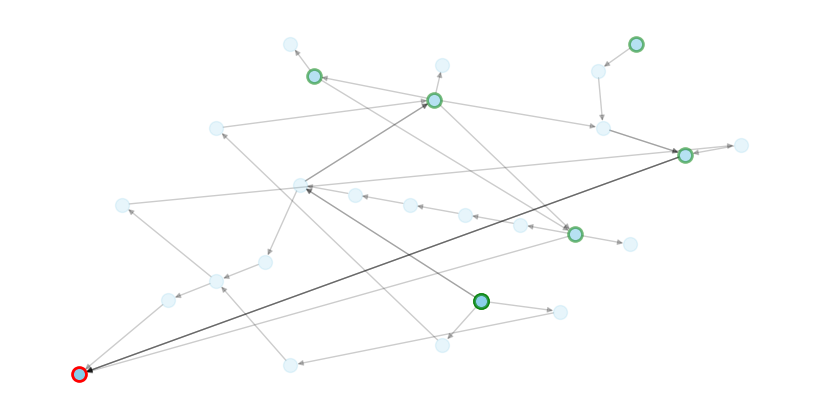

Mao_Zedong
{'Agriculture': (436.7, 367.54), 'Rice': (366.79, 384.77), 'China': (296.88, 402.0), "People's_Republic_of_China": (559.4, 545.3), 'History_of_the_world': (506.6, 350.31), 'Communism': (576.51, 333.08), 'David_Beckham': (167.41, 469.67), 'Manchester_United_F.C.': (100.09, 495.2), 'England': (794.07, 410.93), 'Europe': (150.8, 402.25), 'Asia': (222.27, 341.5), 'Socialism': (638.66, 290.94), 'Chinese_language': (722.6, 402.25), 'Germany': (705.98, 469.67), 'Earth': (258.93, 244.84), 'Beijing': (336.32, 558.8), 'Malaysia': (234.73, 444.13), 'Republic_of_China': (293.46, 529.22), 'History_of_South_Africa_in_the_apartheid_era': (651.12, 341.5), 'Life': (199.68, 203.94), 'Organism': (79.322, 324.15), 'Human': (150.8, 332.82), 'West_Virginia': (436.7, 79.539), 'United_States': (462.73, 153.11), 'Cold_War': (302.86, 112.53), 'Ganesha': (732.97, 572.04), 'Mythology': (732.97, 163.04), 'Religion': (673.72, 203.94), 'Buddhism': (614.46, 244.84), 'India': (652.27, 558.52), 'Stonehenge':

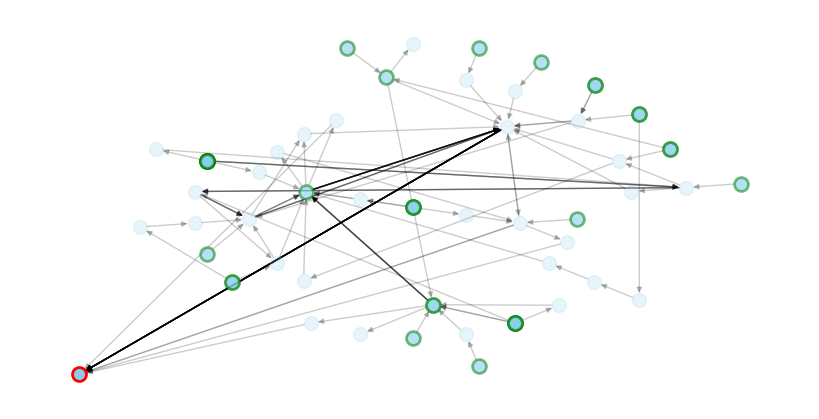

Jesus
{'AIDS': (915.28, 684.22), 'United_States': (742.77, 925.66), 'Judaism': (383.32, 509.82), 'Human': (647.18, 374.06), 'Religion': (724.47, 468.08), 'Christianity': (506.66, 922.54), 'Sub-Saharan_Africa': (631.99, 949.41), 'France': (631.04, 877.41), 'Roman_Catholic_Church': (592.45, 800.93), 'Africa': (383.32, 813.05), 'Latin_America': (327.22, 858.96), 'Guadeloupe': (267.02, 898.47), 'Christopher_Columbus': (206.83, 937.97), 'Jamaica': (146.64, 977.48), 'Dominican_Republic': (86.442, 1017.0), 'Italy': (842.98, 684.2), '20th_century': (415.35, 467.41), 'Jew': (480.57, 503.74), 'Bible': (880.71, 799.91), 'Uganda': (987.06, 689.91), 'Vatican_City': (916.09, 669.03), 'Abraham_Lincoln': (978.07, 746.17), 'United_States_Bill_of_Rights': (859.99, 936.87), 'United_States_Constitution': (906.36, 991.96), 'Benjamin_Franklin': (960.33, 522.57), 'London': (893.9, 550.34), 'Roman_Empire': (829.6, 583.4), 'Jerusalem': (873.05, 509.82), 'World_War_II': (436.99, 446.06), 'South_Africa': (571.53

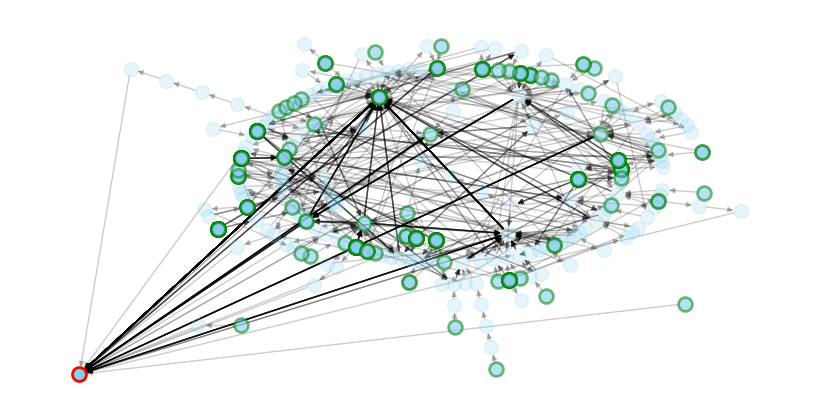

Napoleon_I_of_France
{'AIDS': (633.71, 486.19), '20th_century': (703.26, 467.56), '19th_century': (772.81, 448.92), 'Napoleonic_Wars': (842.35, 430.29), 'Human': (564.17, 504.83), 'Society': (494.62, 523.46), 'Culture': (425.07, 542.1), 'Civilization': (355.53, 560.73), 'French_language': (285.98, 579.37), 'France': (252.4, 684.83), 'Bird_migration': (694.61, 991.65), 'England': (564.17, 936.83), 'English_Channel': (920.55, 861.21), 'Homer': (1123.2, 1232.8), 'Voltaire': (1123.2, 1160.8), 'Paris': (1123.2, 1088.8), 'French_Revolution': (1123.2, 1016.8), 'History_of_the_world': (911.9, 411.65), 'Speed_of_light': (869.64, 199.36), 'Latin': (818.73, 250.27), 'Western_Roman_Empire': (981.45, 616.64), 'Holy_Roman_Empire': (1051.0, 635.27), 'Sahara': (1123.2, 872.83), 'Pig': (1123.2, 800.83), 'Egypt': (1123.2, 944.83), 'William_IV_of_the_United_Kingdom': (146.89, 616.64), 'Ernest_Rutherford': (433.72, 991.65), 'Lance_Armstrong': (77.34, 374.38), 'Tour_de_France': (146.89, 393.02), 'Caroline_

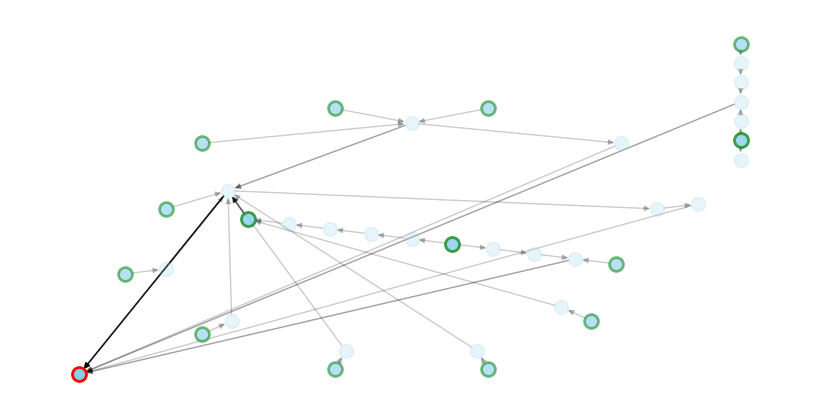

Adolf_Hitler
{'AIDS': (277.91, 734.63), '20th_century': (921.68, 580.98), 'World_War_II': (769.99, 724.12), 'Germany': (291.6, 604.55), 'Aircraft': (912.11, 622.03), 'Ancient_Greece': (553.47, 879.69), 'Europe': (457.74, 786.45), 'Anne_Frank': (219.89, 1007.9), 'Ant': (541.6, 951.2), 'South_Africa': (545.81, 879.32), 'Batman': (351.16, 710.74), 'Scotland': (640.16, 723.13), 'Superman': (907.45, 636.64), 'World_War_I': (916.14, 607.24), 'Great_Britain': (359.48, 719.75), 'United_Kingdom': (351.19, 508.44), 'Bird': (476.59, 323.72), 'Wikipedia_Text_of_the_GNU_Free_Documentation_License': (368.18, 311.47), 'Animal': (372.66, 307.28), 'Latin': (624.83, 311.85), 'Rome': (543.91, 232.85), 'European_Union': (903.55, 647.46), 'Tuberculosis': (377.24, 303.2), 'Eagle': (381.9, 299.21), 'Mammal': (386.64, 295.32), 'Human': (422.0, 271.03), 'Society': (347.61, 234.43), 'Switzerland': (269.03, 722.13), 'Vertebrate': (460.58, 252.27), 'Ostrich': (466.31, 250.07), 'Morocco': (441.16, 182.6), 'Jew': (

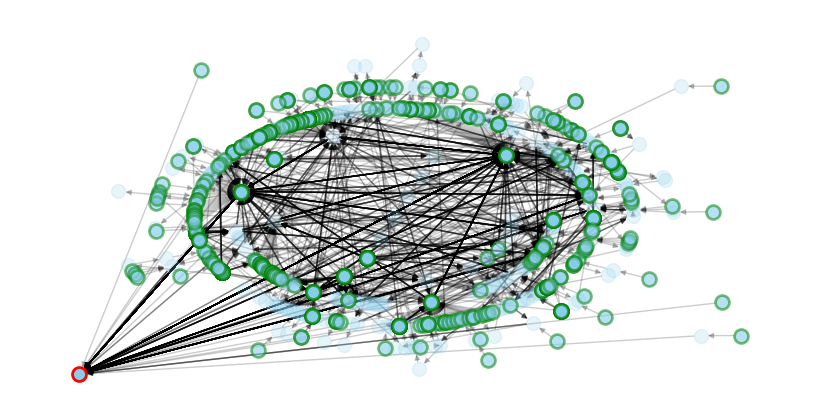

Tony_Blair
{'AIDS': (991.05, 639.07), 'World_Health_Organization': (831.76, 79.216), 'Sweden': (869.66, 18.0), 'United_States': (870.38, 203.98), 'President_of_the_United_States': (962.81, 413.29), 'George_W._Bush': (817.18, 252.49), 'Iraq_War': (670.49, 92.639), 'United_Kingdom': (702.86, 792.77), 'The_Beatles': (895.38, 765.76), 'Space_exploration': (895.38, 127.26), 'Christopher_Columbus': (760.4, 43.681), 'Europe': (831.76, 813.8), 'Black_pepper': (188.83, 328.29), 'Old_English_language': (258.08, 347.99), 'England': (430.78, 676.34), 'Great_Britain': (258.08, 545.03), 'London': (282.08, 606.98), 'Palace_of_Westminster': (245.88, 479.73), 'Speaker_of_the_British_House_of_Commons': (174.18, 486.37), 'Hydrochloric_acid': (604.34, 158.51), 'Middle_Ages': (444.72, 592.03), 'Industrial_Revolution': (551.42, 163.41), 'Humphry_Davy': (604.34, 86.509), 'Vitamin_D': (237.05, 219.09), 'Australia': (298.26, 256.99), 'Winston_Churchill': (245.88, 413.29), 'Prime_Minister_of_the_United_Kingdom'

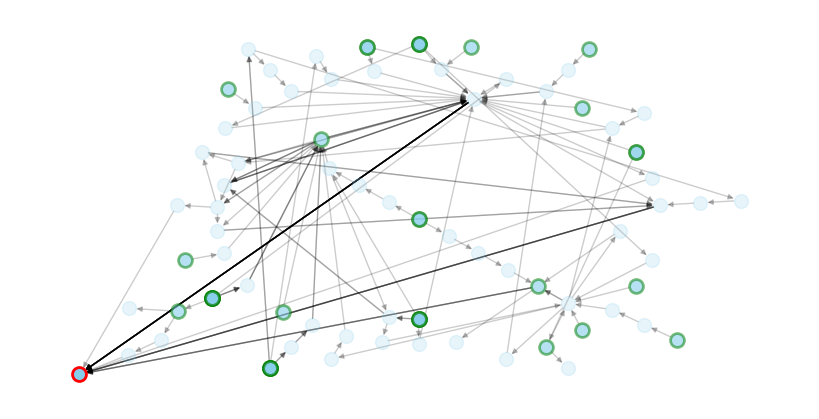

Euclid
{'Aircraft': (436.15, 299.68), 'Airship': (385.24, 350.6), 'Vienna': (334.33, 401.51), 'Architecture': (283.42, 452.42), 'Mathematics': (232.51, 503.33), 'Applied_mathematics': (588.89, 554.24), 'Engineering': (275.03, 616.67), 'Geometry': (119.16, 460.81), 'Hydrogen': (440.35, 217.56), 'Special_relativity': (467.9, 151.04), 'String_theory': (495.45, 84.519), 'Manifold': (523.01, 18.0), 'Helium': (518.28, 295.49), 'Human': (584.8, 267.94), 'Plato': (651.32, 240.38), 'Albatross': (633.22, 949.27), 'Energy': (605.67, 882.75), 'Entropy': (578.11, 816.23), 'Gravitation': (550.56, 749.71), 'Differential_equation': (523.01, 683.19), 'Physics': (717.84, 488.36), 'Atom': (784.36, 515.92), 'Chemical_element': (850.88, 543.47), '7th_century': (52.645, 212.83), 'Library_of_Alexandria': (247.48, 18.0), 'Aristotle': (275.03, 84.519), 'Islam': (119.16, 240.38), 'Golden_Eagle': (921.24, 746.6), 'Europe': (921.24, 818.6), 'Greece': (921.24, 890.6), 'Hellenistic_Greece': (993.24, 943.3), 'Alexan

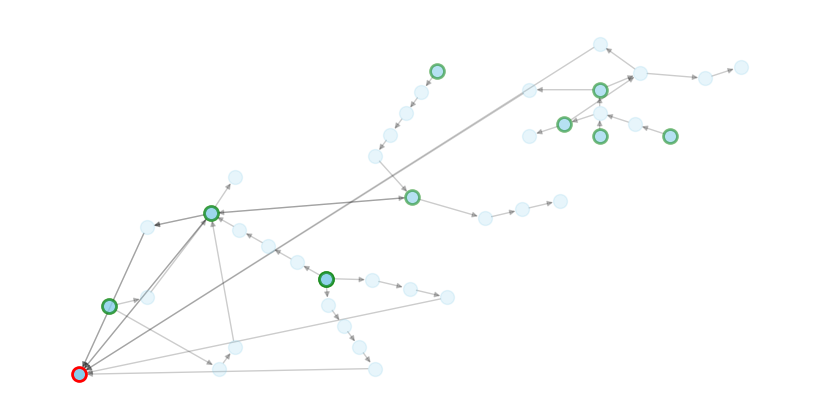

Heraclius
{'Aircraft': (366.26, 903.41), 'Turkey': (411.15, 847.11), 'Constantine_I': (456.04, 790.82), 'Roman_Empire': (616.41, 790.14), 'Go_(board_game)': (776.63, 88.195), 'Chinese_language': (760.6, 158.39), 'United_Nations': (744.58, 228.58), 'George_Byron,_6th_Baron_Byron': (728.56, 298.78), 'Greek_War_of_Independence': (712.54, 368.97), 'Romanticism': (696.52, 439.17), 'Folklore': (680.5, 509.36), 'Culture': (664.48, 579.56), 'Anthropology': (648.45, 649.75), 'China': (632.43, 719.95), 'Byzantine_Empire': (904.95, 790.82), '7th_century': (792.65, 18.0), 'Beach': (32.497, 509.36), 'Geology': (104.5, 509.36), 'Latin': (176.5, 509.36), 'Ancient_Rome': (248.5, 509.36), 'Julius_Caesar': (320.5, 509.36), 'Tripitaka': (1069.7, 321.93), 'Asia': (411.15, 171.61), 'Europe': (1069.7, 696.8), 'Algiers': (792.65, 1000.7), 'Ottoman_Empire': (776.63, 930.53), 'Heraclius': array([0, 0])}


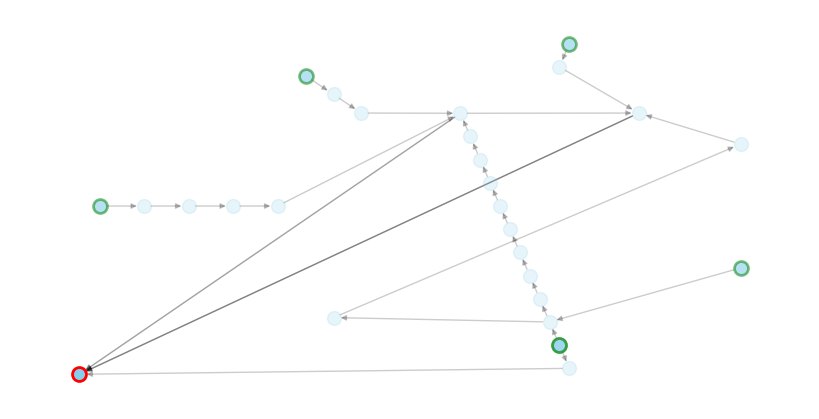

Brothers_Grimm
{'Aluminium': (487.95, 252.11), 'English_language': (423.08, 220.87), 'Germany': (248.45, 214.68), 'United_States': (897.08, 447.65), 'North_America': (846.17, 498.57), 'John_Cabot': (795.25, 549.48), 'Christopher_Columbus': (744.34, 600.39), 'Popular_culture': (693.43, 651.3), 'Literature': (642.52, 702.21), 'Fiction': (897.08, 753.12), 'Mythology': (591.61, 753.12), 'Saxophone': (357.43, 439.17), 'Belgium': (341.41, 368.97), 'German_language': (261.3, 298.78), 'British_monarchy': (325.39, 18.0), 'United_Kingdom': (309.36, 88.195), 'Europe': (293.34, 158.39), 'Great_white_shark': (77.343, 158.39), 'Australia': (149.34, 158.39), 'Aachen': (203.56, 45.806), 'Community': (540.7, 396.74), 'Culture': (591.61, 447.65), 'Phosphorus_trichloride': (487.95, 64.671), 'Alcohol': (423.08, 95.91), 'Vanilla': (358.21, 127.15), 'Vowel': (158.67, 327.27), 'Brothers_Grimm': array([0, 0])}


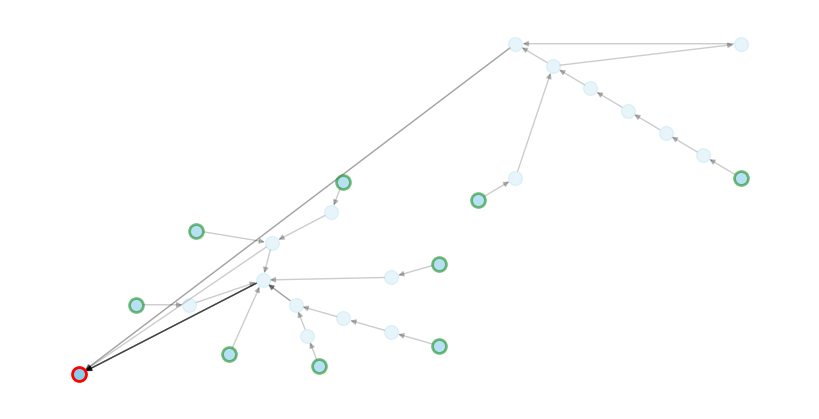

In [14]:
j = 0
source_list = []

for people in target_people_list.iloc[10:20]:
    graph = nx.MultiDiGraph()
    target_article = people
    print(target_article)
    source_list = []

    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
 
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                target = partial_path[k+1]
                if target != target_article:
                    #target = str(i) + '.' + target
                    target = target
                # Add edges to the graph
                #cur_nod = str(i) + '.' + path_target.path[j]
                cur_nod = partial_path[k]
                if k == 0: 
                    source_list.append(cur_nod)
                graph.add_edge(cur_nod, target)
                graph.add_node(cur_nod)


    plt.figure(figsize=(8, 4))

    #pos = nx.shell_layout(G = graph.subgraph(set(graph) - {target_article}))
    pos = nx.nx_agraph.graphviz_layout(G = graph.subgraph(set(graph) - {target_article}), prog="twopi", root=0)
    pos[target_article] = np.array([0, 0])

    print(pos)



    #node size
    nd = 100
    color_noded = 'skyblue'
    color_edge_target = 'red'
    color_edge_source = 'green'
    #nx.flow_hierarchy(graph)
    nx.draw(graph, pos, with_labels=False, node_size=nd, node_color= color_noded, font_size=5, font_color='black', font_weight='bold', arrowsize=8, alpha = 0.2)
    nx.draw_networkx_nodes(graph, pos, nodelist=[target_article], node_color= color_noded, edgecolors = color_edge_target, node_size=nd, linewidths=2)
    nx.draw_networkx_nodes(graph, pos, nodelist=source_list, node_color= color_noded, edgecolors=color_edge_source, node_size=nd, linewidths=2, alpha = 0.5)
 

    plt.show()


# Repartition of last linkage

Dans mes plots on prends pas en compte le count des paths dans l'épaisseur des edge, ça pourrait être qch à étudier

In [13]:

# Add the name of the last article before reaching the target in the path 
path_target_people['last_before_target'] = 'None'
for i, row in path_target_people.iterrows():
    if len(row.path[-1]) <2:
        print(row.path[-1])
        print(i)
    path_target_people.loc[i, 'last_before_target'] = row.path[-1][-2]
path_target_people

# Count duplicates of the target, last_before_target pairs 
last_link = path_target_people.loc[:,['target', 'last_before_target']]
last_link['count_duplicates'] = last_link.groupby(['target', 'last_before_target'])['last_before_target'].transform('count')
last_link.drop_duplicates(subset=['target', 'last_before_target'], inplace=True)

# Add the percentage that the name of the last article before reaching the target represent
last_link['repartition_perc'] = 1000.0
for people in last_link.target.unique():
    l = last_link[last_link.target == people].count_duplicates
    last_link.loc[last_link.target == people, 'repartition_perc'] = last_link.loc[last_link.target == people, 'count_duplicates']/last_link[last_link.target == people].count_duplicates.sum()*100

# Add the general count of value according to the category of the last article before reaching the target
last_link['category_last'] = [ ('people' if last in list_people.values else 'non_people') for last in last_link.last_before_target ]
target_cat_last = last_link.groupby(['target', 'category_last'])['count_duplicates'].sum().reset_index()
target_cat_last.rename(columns={'count_duplicates': 'count_by_categories'}, inplace = True)
last_link = last_link.merge(target_cat_last, on = ['target', 'category_last'], how = 'left')

display(last_link)

,target,last_before_target,count_duplicates,repartition_perc,category_last,count_by_categories
0,John_F._Kennedy,President_of_the_United_States,12,54.545455,non_people,21
1,Elizabeth_I_of_England,Francis_Drake,1,5.000000,people,8
2,Elizabeth_I_of_England,James_I_of_England,1,5.000000,people,8
3,Elizabeth_I_of_England,Henry_VIII_of_England,5,25.000000,people,8
4,Elizabeth_I_of_England,Windsor_Castle,1,5.000000,non_people,12
...,...,...,...,...,...,...
1459,Felix_Mendelssohn,Romanticism,1,25.000000,non_people,4
1460,Zoroaster,Persian_Empire,1,25.000000,non_people,4
1461,Christopher_Columbus,15th_century,1,6.666667,non_people,15
1462,Robert_Oppenheimer,Richard_Feynman,1,20.000000,people,2


In [14]:
last_link[last_link.target == 'Robert_Oppenheimer']

,target,last_before_target,count_duplicates,repartition_perc,category_last,count_by_categories
825,Robert_Oppenheimer,History_of_nuclear_weapons,3,60.0,non_people,3
1214,Robert_Oppenheimer,Linus_Pauling,1,20.0,people,2
1462,Robert_Oppenheimer,Richard_Feynman,1,20.0,people,2


In [15]:
last_people = last_link.loc[last_link.category_last == 'people',]
last_not_people = last_link.loc[last_link.category_last == 'non_people',]

In [16]:
print(last_not_people.count_duplicates.sum(), last_people.count_duplicates.sum())
print(len(last_not_people.count_duplicates), len(last_people.count_duplicates))

5129 781
1128 336


# Autre

In [5]:
result_dict, all_articles = create_dictionary_from_tsv("dataset/wikispeedia_paths-and-graph/categories.tsv")

In [ ]:
result_dict

In [10]:
print(len(all_articles), len(result_dict))

5204 4598


In [74]:
target_cat_last

,target,category_last,count_by_categories
0,Abel_Tasman,non_people,3
1,Abel_Tasman,people,3
2,Abraham_Lincoln,non_people,35
3,Adam_Smith,non_people,8
4,Adam_Smith,people,1
...,...,...,...
639,Zachary_Taylor,people,1
640,Zheng_He,non_people,5
641,Ziad_Jarrah,non_people,5
642,Zionism,non_people,10


583.0 0.0
46.0 0.0


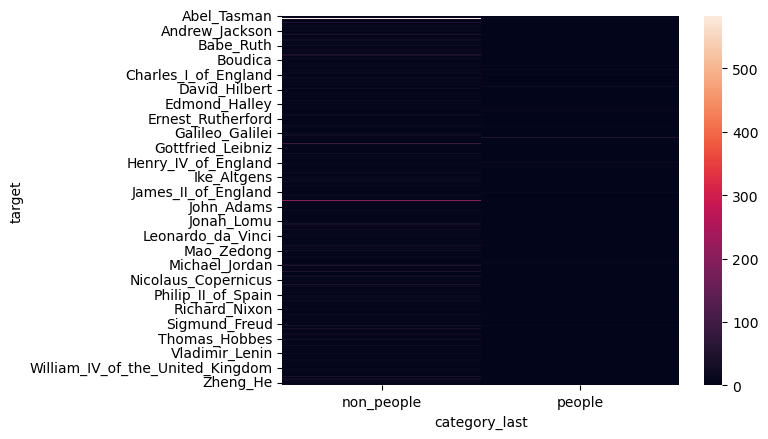

/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse i

<Axes: xlabel='category_last', ylabel='target'>

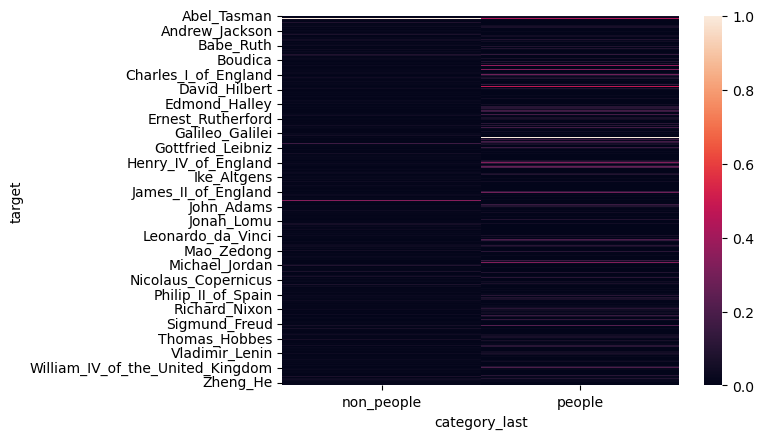

In [18]:
a = target_cat_last.pivot(index="target", columns="category_last", values="count_by_categories")
a.fillna(0, inplace = True)
print(max(a.non_people), min(a.non_people))
print(max(a.people), min(a.people))
import seaborn as sns
sns.heatmap(a, annot=False)
plt.show()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
a[['non_people', 'people']] = scaler.fit_transform(a)
sns.heatmap(a, annot=False)

<Axes: xlabel='category_last', ylabel='target'>

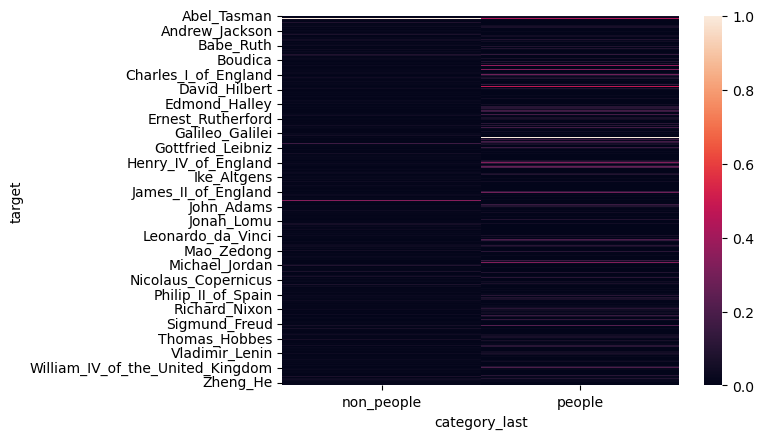

In [83]:
import seaborn as sns
sns.heatmap(a, annot=False)
